# Practical Work 3 - Convolutional neural network (CNN)
# Question 2 : CNN For Colorize a grayscale image

## Introduction

Main goal: 
The CNN is trained with grayscale images as input and colored images as output. The training has already been carried out, so you must build the model and load the network parameters.

## Imports

In [3]:
# Classical libraries
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os 
import os.path
from os import path

# Keras via Tensorflow library
import tensorflow.keras as tk

# Import datasets, layers, models and optimizers.
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Conv2D,Flatten,Reshape,Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import plot_model

## CIFAR10 dataset loading
The Cifar10 data is loaded. The parameters of the database are retrieved (number of examples, of classes, size of the retina).

In [4]:
# Cifar10 dataset loading
# The data, shuffled and split between train and test sets:
(x_train, _), (x_test, _) = cifar10.load_data()
num_classes = 10
print('X_train shape: {}'.format(x_train.shape))
print('train samples: {}'.format(x_train.shape[0]))
print('test samples: {}'.format(x_test.shape[0]))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# input image dimensions
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]
print('Number of rows {}'.format(img_rows))
print('Number of columns {}'.format(img_cols))
print('Number of channels {}'.format(channels))

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
X_train shape: (50000, 32, 32, 3)
train samples: 50000
test samples: 10000
Number of rows 32
Number of columns 32
Number of channels 3


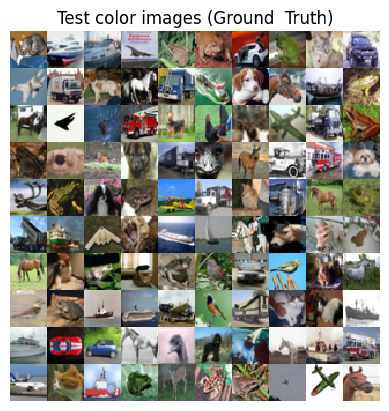

In [5]:
# create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

# display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

(10000, 32, 32, 1)


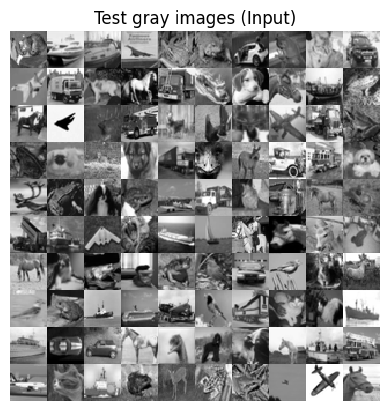

In [6]:
def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

x_train_gray = x_train_gray.reshape(list(x_train_gray.shape) + [1])
x_test_gray = x_test_gray.reshape(list(x_test_gray.shape) + [1])
print(x_test_gray.shape)

# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [80]:
# network parameters
input_shape = (img_rows, img_cols,1)
batch_size  = 32
kernel_size = 3
strides     = 2
padding     = 'same'

# Create a sequential model
model = Sequential()
# Add layers : stack of Conv2D(filters=64,strides=2)-Conv2D(filters=128,strides=2)-Conv2D(filters=256,strides=2)-Flatten-Dense(256)-Dense(4096)-Reshape-Conv2DTranspose(filters=256,strides=2)-Conv2DTranspose(filters=128,strides=2)-Conv2DTranspose(filters=64,strides=2) - Conv2DTranspose(filters=3(number of channels),strides=1)

# TODO : Create the model
model.add(Conv2D(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu', input_shape=input_shape))
model.add(Conv2D(128, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'))
model.add(Conv2D(256, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(Reshape((4, 4, 256)))
model.add(Conv2DTranspose(256, kernel_size=kernel_size, strides=strides, activation='relu', padding=padding))
model.add(Conv2DTranspose(128, kernel_size=kernel_size, strides=strides, activation='relu', padding=padding))
model.add(Conv2DTranspose(64, kernel_size=kernel_size, strides=strides, activation='relu', padding=padding))
model.add(Conv2DTranspose(3, kernel_size=kernel_size, activation='sigmoid', padding=padding))

# Print a summary of the network
model.summary()

# Save an image file with the structure of the model
plot_model(model, '%s/model.png' % imgs_dir, show_shapes=True)

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_105 (Conv2D)             │ (None, 16, 16, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_33 (Reshape)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_126            │ (None, 8, 8, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_127            │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_128            │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_129            │ (None, 32, 32, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,431,811 (13.09 MB)

 Trainable params: 3,431,811 (13.09 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Loading weights from disk
[Link for China](https://tensorflow.google.cn/guide/keras/save_and_serialize?hl=en#apis_for_saving_weights_to_disk_loading_them_back)


In [81]:

# TODO : load the parameters inside the file 'colorized_model.015.h5'
# Online documentation => Keras function : load_weights(.......)

model.load_weights('colorized_model.015.h5')
model.compile(optimizer='adam', loss='mean_squared_error')


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


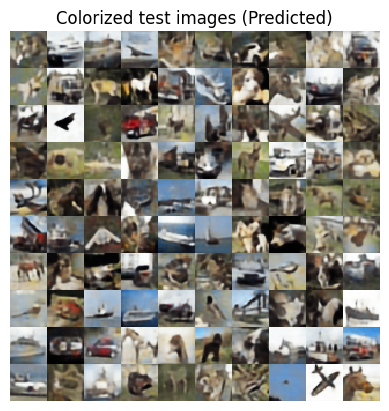

In [82]:
# predict the autoencoder output from test data
x_decoded = model.predict(x_test_gray)

# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

In [83]:
print("Evaluate on test data")
results = model.evaluate(x_test_gray, x_test, batch_size=128)
print("test loss, test mean_absolute_error:", results)



Evaluate on test data
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0075
test loss, test mean_absolute_error: 0.007466960232704878
